# Machine Learning (ML) 
## lecture 12 Basic Text Classification with Movie Reviews

## Text Classification with IMDB Movie Reviews


This notebook classifies movie reviews as *positive* or *negative* using the text of the review. 

This is an example of *binary*—or two-class—classification.  

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). 

Imdb dataset split into 25,000 reviews for training and 25,000 reviews for testing. 

![image.png](attachment:image.png)

## 1. Setup

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization, SimpleRNN
from tensorflow.keras.utils import to_categorical, plot_model
tf.__version__

'2.7.0'

In [3]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.7.0
Eager mode:  True
GPU is available


## 2. Download the IMDB dataset

- The reviews (sequences of words) have been converted to sequences of integers

- `vocal_size` ~ 10,000 most frequently occurring words.

In [4]:
vocal_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocal_size)

## 3. Explore the data 

- Each `y_train, y_test` is an integer value of either `0`(negative) or `1`(positive) review.

In [5]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

print("Test entries: {}, labels: {}".format(len(X_test), len(y_test)))

Training entries: 25000, labels: 25000
Test entries: 25000, labels: 25000


- 첫 샘플 

In [6]:
print(X_train[0])
print('-------')
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
-------
1


- Check the first data : Movie reviews may be different lengths. 

In [7]:
len(X_train[0]), len(X_train[1])

(218, 189)

- The 5 most frequently used words

In [8]:
imdb_get_word_index = {}

for key, value in imdb.get_word_index().items():
    imdb_get_word_index[value] = key
    
for i in range(1, 6):
    print('{}-th word which is used the most frequently = {}'.format(i, imdb_get_word_index[i])) 

1-th word which is used the most frequently = the
2-th word which is used the most frequently = and
3-th word which is used the most frequently = a
4-th word which is used the most frequently = of
5-th word which is used the most frequently = to


- Convert the integers back to words

In [9]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [10]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

-  display the text for the first review:

In [11]:
decode_review(X_train[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 4. Prepare the data

- pad the arrays so they all have the same length,

In [12]:
seq_len = 256
print('Before pad_sequences: ', len(X_train[0]))

Before pad_sequences:  218


In [13]:
X_train = pad_sequences(X_train, maxlen=seq_len, padding = 'pre')
X_test = pad_sequences(X_test, maxlen=seq_len, padding = 'pre')
print('After X_train pad_sequences: ', len(X_train[0]))
print('After X_test pad_sequences: ', len(X_test[0]))

After X_train pad_sequences:  256
After X_test pad_sequences:  256


## 5. Build the model

- Construct a model using the Embedding layer

![image.png](attachment:image.png)

In [14]:
embedding_dim = 128

- The first layer is an Embedding layer.
- The resulting dimensions are: (batch, sequence, embedding, seq_len).

In [15]:
m1 = Sequential()

m1.add(Embedding(vocal_size, embedding_dim, input_length = seq_len))
m1.add(SimpleRNN(embedding_dim))               
m1.add(Dense(1, activation='sigmoid'))

In [16]:
m2 = Sequential()

m2.add(Embedding(vocal_size, embedding_dim, input_length = seq_len))
m2.add(Bidirectional(LSTM(embedding_dim)))               
m2.add(Dropout(0.2))
m2.add(Dense(embedding_dim, activation = 'relu'))
m2.add(BatchNormalization())
m2.add(Dropout(0.2))
m2.add(Dense(1, activation='sigmoid'))

In [17]:
m3 = Sequential()
m3.add(Embedding(input_dim = vocal_size, output_dim = embedding_dim, input_length = seq_len))
m3.add(Bidirectional(LSTM(embedding_dim, return_sequences = True )))
m3.add(Bidirectional(LSTM(embedding_dim)))
m3.add(Dense(embedding_dim, activation = 'relu'))
m3.add(Dropout(0.5))
m3.add(Dense(1, activation = 'sigmoid'))

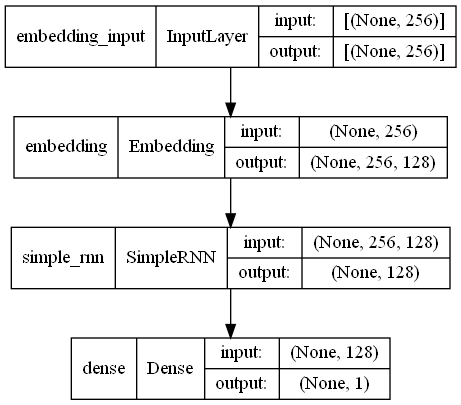

In [18]:
model = m1; plot_model(model, show_shapes=True)

In [19]:
#model = m2; plot_model(model, show_shapes=True)

In [20]:
#model = m3; plot_model(model, show_shapes=True)

In [21]:
model = m1

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [23]:
X_train.shape, y_train.shape

((25000, 256), (25000,))

In [24]:
num_small = 10000

pX_train = X_train[num_small:]
py_train = y_train[num_small:]

x_val = X_train[:num_small]
y_val = y_train[:num_small]

In [25]:
print(x_val.shape, y_val.shape)
print(pX_train.shape, py_train.shape)

(10000, 256) (10000,)
(15000, 256) (15000,)


## 6. Train the model

Colab: Elapsed 2933.763 seconds.

In [26]:
import time
start = time.perf_counter()

history = model.fit(X_train, y_train, epochs=10, batch_size=64, 
                    validation_data=(x_val, y_val),
                    verbose=1)

elapsed = time.perf_counter() - start
print('============================\n Elapsed %.3f seconds.' % elapsed)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
391/391 [==============================] - ETA: 0s - loss: 0.6829 - acc: 0.5601WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000018FB0F161F8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

## 7. Evaluate the model


In [27]:
X_test.shape, y_test.shape

((25000, 256), (25000,))

In [28]:
test_loss, test_acurracy = model.evaluate(X_test, y_test)

print("Test accuracy: {}".format(test_acurracy))
print("Test loss: {}".format(test_loss))

782/782 [==============================] - 54s 69ms/step - loss: 0.5326 - acc: 0.7910
Test accuracy: 0.7910400032997131
Test loss: 0.5326084494590759


In [29]:
# Generate predictions
predictions = model.predict(X_train[0:20])
print(predictions)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[0.95647436]
 [0.09762806]
 [0.09510067]
 [0.9884554 ]
 [0.08556186]
 [0.03566658]
 [0.9776307 ]
 [0.02483661]
 [0.9840465 ]
 [0.05688852]
 [0.9931352 ]
 [0.09034158]
 [0.14482702]
 [0.01156923]
 [0.01982516]
 [0.03456545]
 [0.9952172 ]
 [0.6925166 ]
 [0.05652772]
 [0.9745355 ]]


In [30]:
for i in range(2):
  INDEX_FROM=3   # word index offset
  word_to_id = imdb.get_word_index()
  word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
  word_to_id["<PAD>"] = 0
  word_to_id["<START>"] = 1
  word_to_id["<UNK>"] = 2
  word_to_id["<UNUSED>"] = 3

  id_to_word = {value:key for key,value in word_to_id.items()}
  print('=================================================')
  print(f'Sample = {i} | Length = {len(X_test[i])}')
  print('=================================================')
  print(' '.join(id_to_word[id] for id in X_test[i] ))


Sample = 0 | Length = 256
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

## 8. Create a graph of accuracy and loss over time

- `model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

- There are four entries: one for each monitored metric during training and validation. 
- We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

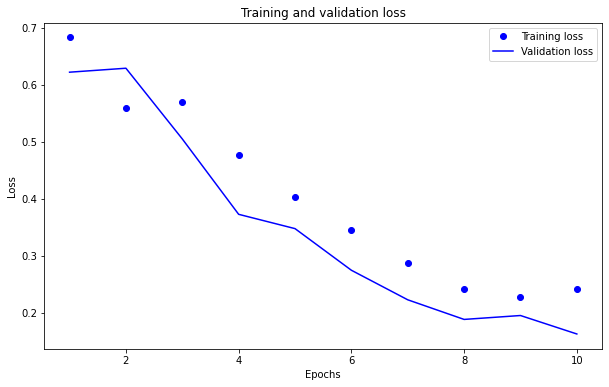

In [32]:
plt.figure(figsize=(10, 6))

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

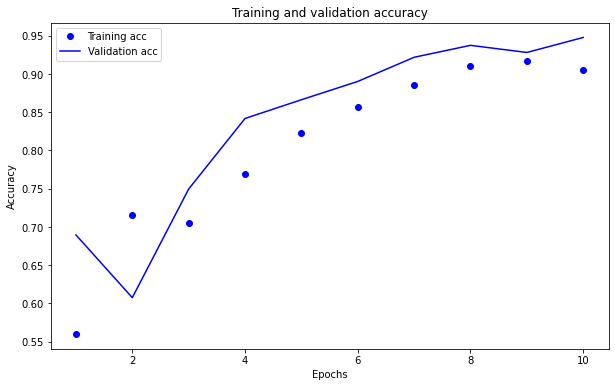

In [33]:
#plt.clf()   # clear figure
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 9. Model Evaluation : ROC Curve

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_hat = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

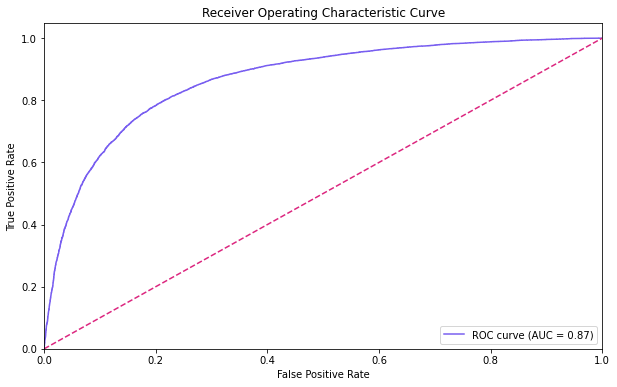

In [35]:
fig = plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='#785ef0', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#dc267f', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

plt.show()

In [36]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
y_pred = np.where(y_hat>=optimal_threshold, 1, 0)
print('Balanced Accuracy Score:',balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Threshold value is: 0.59686714
Balanced Accuracy Score: 0.79244
[[9972 2528]
 [2661 9839]]


# Model M3: Stack two or more LSTM layers

### return_sequence : True or False 
return_sequence = False:
- It returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). 

return_sequence = True:
- the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape (batch_size, timesteps, output_features)).

![image.png](attachment:image.png)